# Solving the diffusion equation in r (under the no-z approximation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.optimize import curve_fit

In [9]:
#Necessary functions

#Initialize magnetic field components (Br, Bphi) with random curves
np.random.seed(21)

#Define random but smooth functions for Br and Bphi
def random_curve1(x, frequency):
    return np.sin( np.pi * frequency * x - 1.5*x) + np.cos(np.pi * frequency * x- x) 
def random_curve2(x, frequency):
    return np.sin( np.pi * frequency * x + x) - np.sin(np.pi * frequency * x)



def initial_condition(r):
    #noise_amplitude = 0.01
    
    Br_0 = 1
    Bphi_0 = 1
    frequency=0.1
    #Br=Br_0* np.sin( np.pi  *0.1* r +2*r) - np.cos(2*np.pi *0.1* r)
    #Bphi= Bphi_0* -0.05*r**2 - np.cos(3*np.pi*0.075*r) + noise_amplitude * np.random.rand(len(r))
    Br = random_curve1(r, frequency) 
    Bphi = random_curve2(r, frequency)

    return Br, Bphi

def time_derivative(B, dBdr, ddBddr, r):
    return eta * (ddBddr + (dBdr/r) - B/(r**2) - (((np.pi ** 2) * B) / (4 * (h ** 2))))


def spatial_derivative(B, dx):
    B_copy = np.copy(B)
    
    #putting relative anti-symmetric ghost zone
    B_copy = np.append(-np.flip(B_copy[1:4]), B_copy)
    B_copy = np.append(B_copy, -np.flip(B_copy[-4:-1]))
    B_copy[0:3] = B_copy[0:3] + (2 * B[0])
    B_copy[-3:] = B_copy[-3:] + (2 * B[-1])
    
    #To append the Ghost zones
    B = np.append(B, np.zeros(3))
    B = np.append(np.zeros(3), B)
    
    
    der_1 = []
    der_2 = []
    
    #2nd order finite difference
    for i in range(3,len(B_copy)-3):
        der_1.append(((B_copy[i+1] - B_copy[i-1]) / (2.0 * dx)))
        der_2.append((B_copy[i+1] - 2.0 * B_copy[i] + B_copy[i-1]) / (dx**2))
    
    der_1 = np.array(der_1)
    der_2 = np.array( der_2)
    
    return der_1, der_2




In [10]:

#Parameters
eta = 0.02  #Turbulent magnetic diffusivity
t = 100
L = 10  #Length of the spatial domain
Nr = 100  #Number of spatial grid points
Nt = 1000  #Number of time steps
dr = L / (Nr - 1)  #Spatial step size
dt = T / (Nt - 1)
r_i = -L/2
r_f = L/2
h = 1
#dt = (0.08*np.pi* dx**2) / eta_T  #Time step size

#Initialize spatial grid
r = np.linspace(-L/2, L/2, Nr)
tspan = np.linspace(0, t, Nt)


##############################################################################################

#defining intial B_r

Br = initial_condition(r)[0]
Bphi = initial_condition(r)[1]

Br_list = [Br] 

# contains initial condition
# print('Br:', Br)

# The Boundary Conditions are easily observed in the plots
# Br[0] = 0
# Br[-1] = 0
# Bphi[0] = 0
#Bphi[-1] = 0

Bphi_list = [Bphi]

dr = r[1] - r[0]


#Runge-Kutta method for solving the diffusion equation
for i in range(1, Nt+1):

    #for B_r
    dBrdr, ddBrddr = spatial_derivative(Br, dr)
    
    k1 = dt * time_derivative(Br, dBrdr, ddBrddr, r)
    k2 = dt * time_derivative(Br + (k1/2), dBrdr, ddBrddr, r)
    k3 = dt * time_derivative(Br + (k2/2), dBrdr, ddBrddr, r)
    k4 = dt * time_derivative(Br + k3, dBrdr, ddBrddr, r)
    Br = Br + (k1 + (2*k2) + (2*k3) + k4)/6
    
    Br_list.append(Br) #appends Br at next time step to list of Brs
    
    #for B_phi
    dBphidr, ddBphiddr = spatial_derivative(Bphi, dr)

    k1 = dt * time_derivative(Bphi, dBphidr, ddBphiddr, r)
    k2 = dt * time_derivative(Bphi + (k1/2), dBphidr, ddBphiddr, r)
    k3 = dt * time_derivative(Bphi + (k2/2), dBphidr, ddBphiddr, r)
    k4 = dt * time_derivative(Bphi + k3, dBphidr, ddBphiddr, r)

    Bphi = Bphi + (k1 + (2*k2) + (2*k3) + k4)/6

    Bphi_list.append(Bphi) #appends Bphi at next time step to list of Bphis


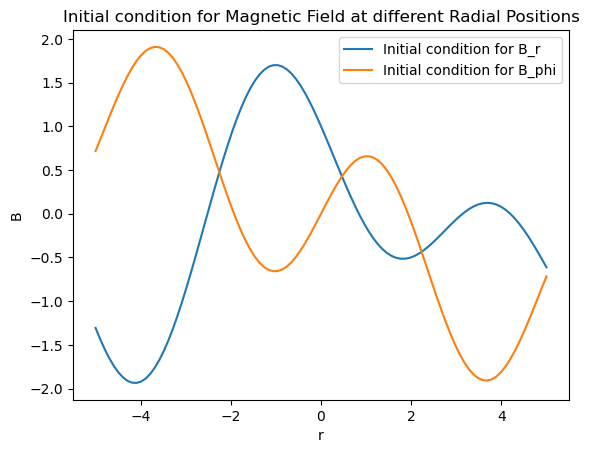

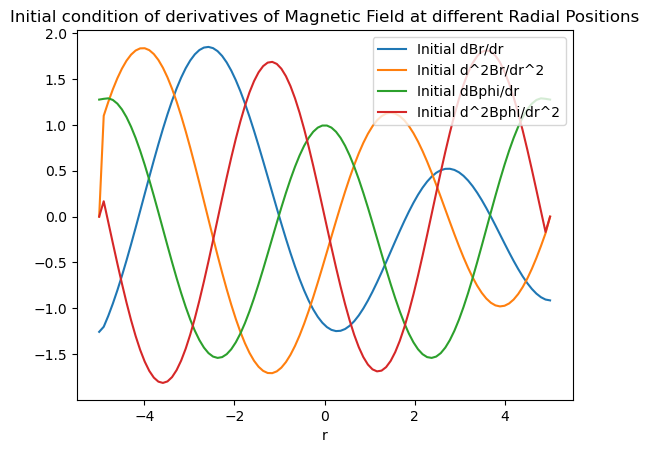

In [11]:
##plotting initial condition
plt.plot(r, Br_list[0], label = 'Initial condition for B_r')
plt.plot(r, Bphi_list[0], label = 'Initial condition for B_phi')
plt.xlabel('r')
plt.ylabel('B')
plt.title('Initial condition for Magnetic Field at different Radial Positions')

plt.legend(loc='upper right')
plt.show()

dBrdr, ddBrddr = spatial_derivative(Br_list[0], dr)
dBphidr, ddBphiddr = spatial_derivative(Bphi_list[0], dr)

plt.plot(r, dBrdr, label = 'Initial dBr/dr')
plt.plot(r, ddBrddr, label = 'Initial d^2Br/dr^2')
plt.plot(r, dBphidr, label = 'Initial dBphi/dr')
plt.plot(r, ddBphiddr, label = 'Initial d^2Bphi/dr^2')
plt.title('Initial condition of derivatives of Magnetic Field at different Radial Positions')

plt.xlabel('r')
plt.legend(loc='upper right')
plt.show()





## Exploring the evolution of the magnetic field magnitude

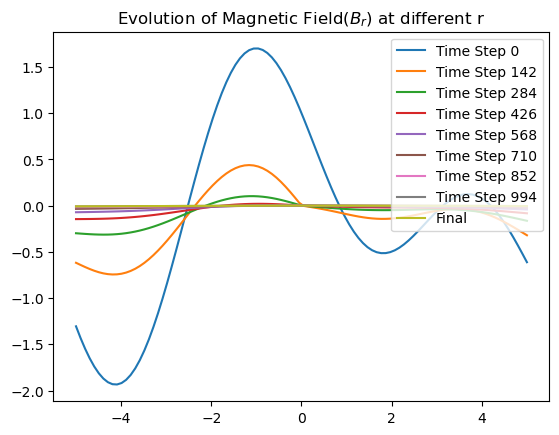

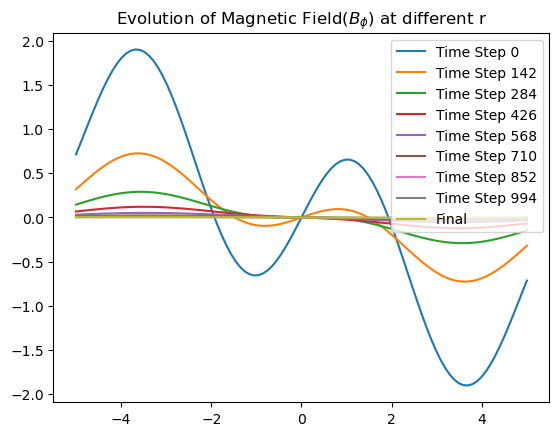

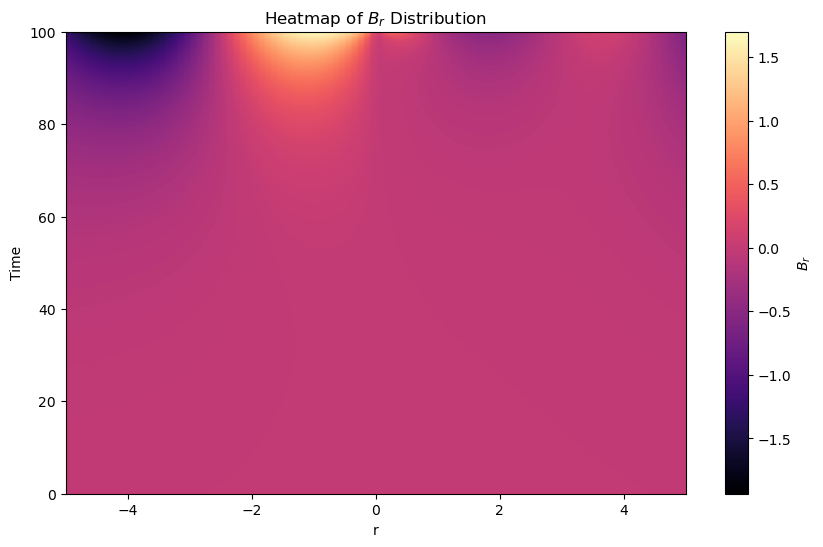

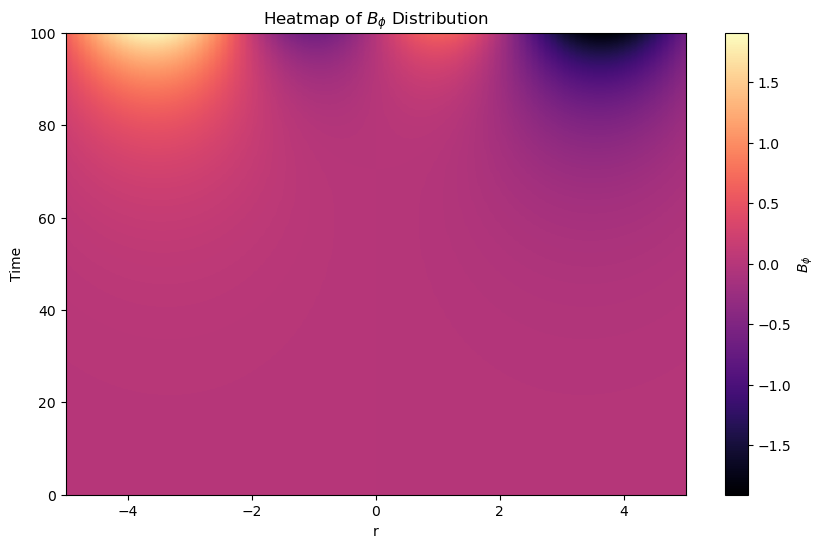

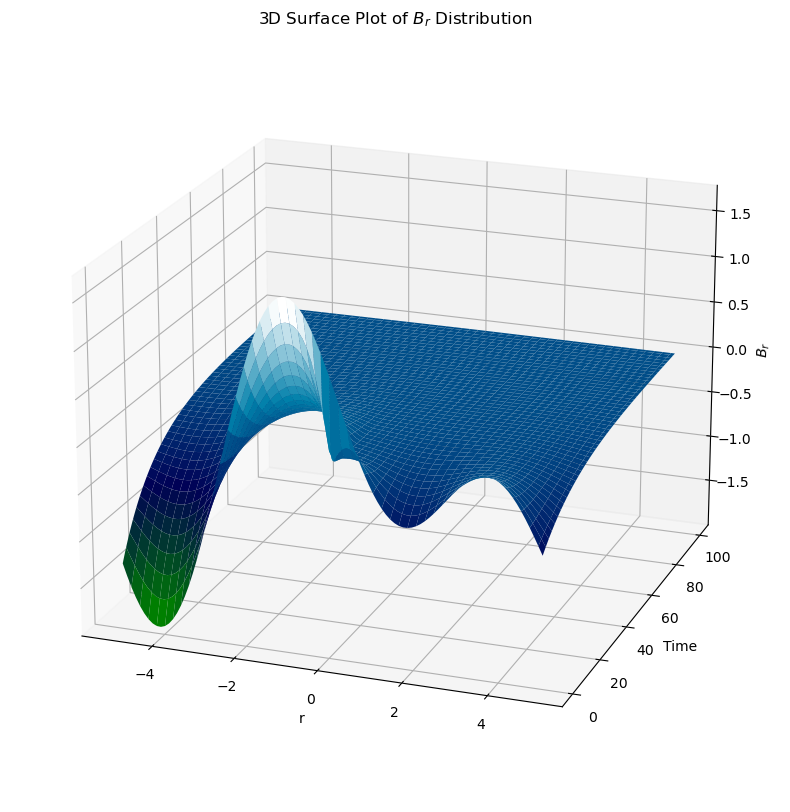

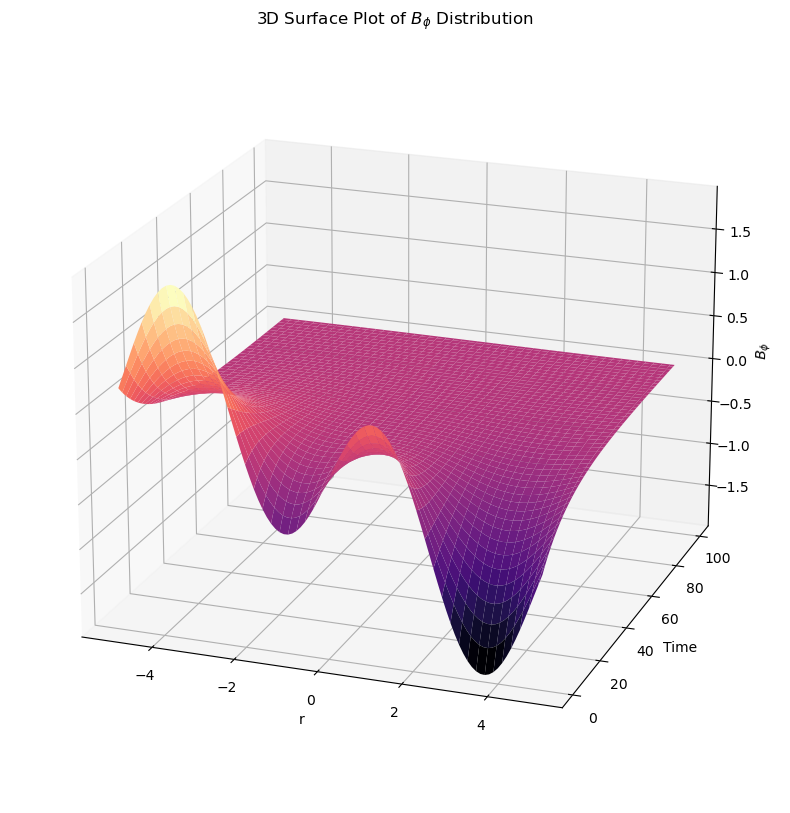

In [12]:
#plotting EVOLUTION


fig, ax = plt.subplots()
for i in range(0, Nt, Nt//7):
    ax.plot(r, Br_list[i], label=f'Time Step {i}')
ax.plot(r, Br_list[-1], label=f'Final')

ax.legend(loc='upper right')
plt.title('Evolution of Magnetic Field($B_r$) at different r')

plt.show()

fig, ax = plt.subplots()

for i in range(0, Nt, Nt//7):
    ax.plot(r, Bphi_list[i], label=f'Time Step {i}')
ax.plot(r, Bphi_list[-1], label=f'Final')

ax.legend(loc='upper right')
plt.title('Evolution of Magnetic Field($B_{\phi}$) at different r')

plt.show()


# Modify this section to convert lists to NumPy arrays
Br_array = np.array(Br_list)
Bphi_array = np.array(Bphi_list)

# Modify this section to plot heat map
plt.figure(figsize=(10, 6))
plt.imshow(Br_array, extent=[r_i, r_f, 0, t], aspect='auto', cmap='magma')
plt.colorbar(label='$B_r$')
plt.title('Heatmap of $B_r$ Distribution')
plt.xlabel('r')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(Bphi_array, extent=[r_i, r_f, 0, t], aspect='auto', cmap='magma')
plt.colorbar(label='$B_{\phi}$')
plt.title('Heatmap of $B_{\phi}$ Distribution')
plt.xlabel('r')
plt.ylabel('Time')
plt.show()

# Modify this section to plot 3D surface plot
R, T = np.meshgrid(r, np.linspace(0, t, Nt + 1))

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, Br_array, cmap='ocean')
ax.set_title('3D Surface Plot of $B_r$ Distribution')
ax.set_xlabel('r')
ax.set_ylabel('Time')
ax.set_zlabel('$B_r$')

#plt.subplots_adjust(left=0.1, right=1.2, bottom=0.1, top=0.9)
ax.view_init(elev=20,azim=-70)
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, Bphi_array, cmap='magma')
ax.set_title('3D Surface Plot of $B_{\phi}$ Distribution')
ax.set_xlabel('r')
ax.set_ylabel('Time')
ax.set_zlabel('$B_{\phi}$')
ax.view_init(elev=20,azim=-70)
plt.show()



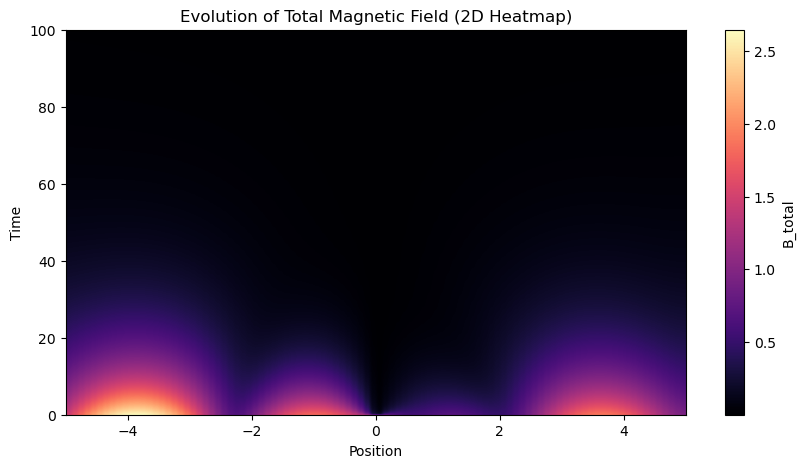

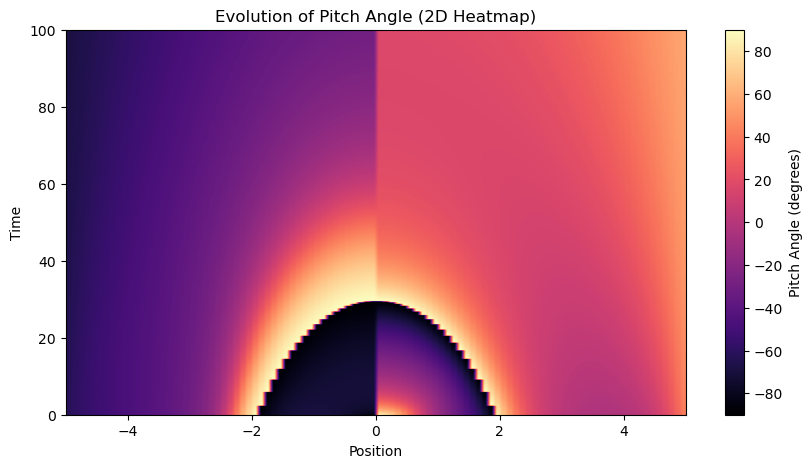

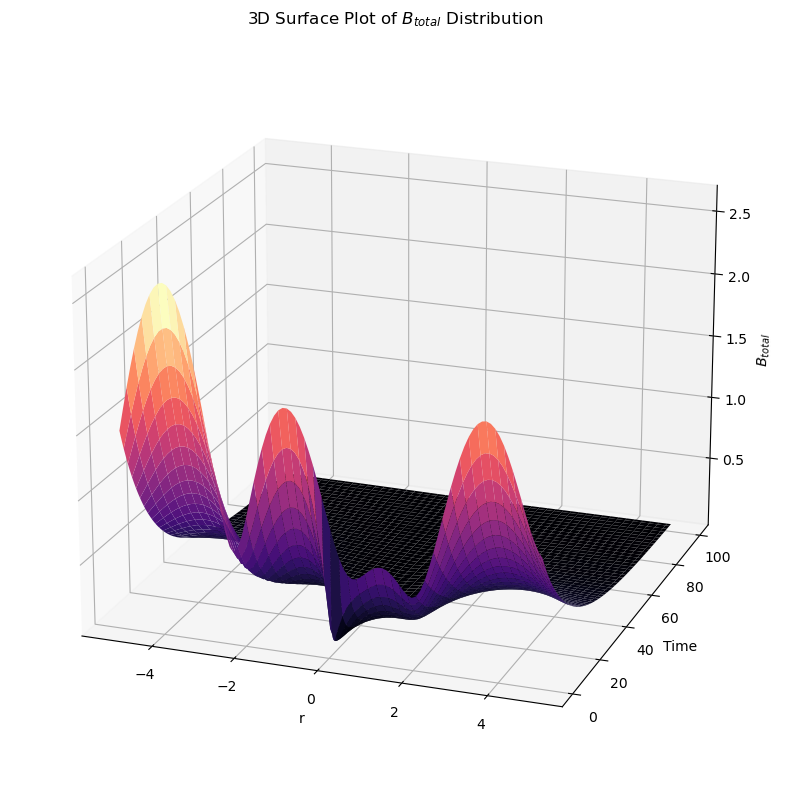

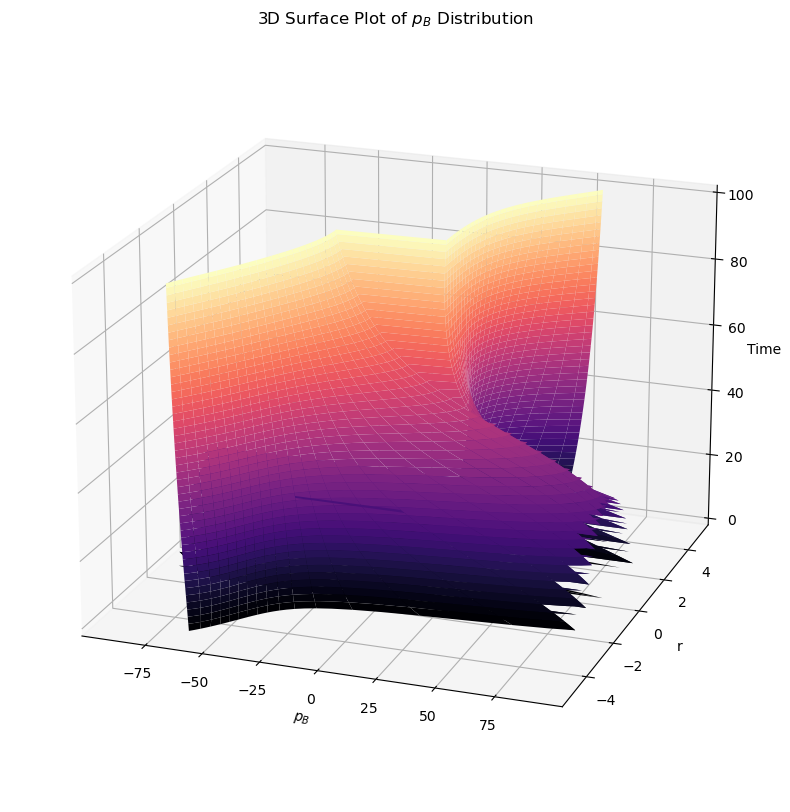

In [13]:
# Initialize arrays to store the total magnetic field and pitch angle

B_total = []
pitch_angle = []

# Modify this section to convert lists to NumPy arrays
Br_array = np.array(Br_list)
Bphi_array = np.array(Bphi_list)

pitch_angle = np.degrees(np.arctan(Br_array/ Bphi_array))
B_total = np.sqrt(Br_array**2 + Bphi_array**2)


#Modify this section to convert lists to NumPy arrays
B_total_array = np.array(B_total)
pitch_angle_array = np.array(pitch_angle)

# Plot 2D heatmap of B_total evolution
plt.figure(figsize=(10, 5))
plt.imshow(B_total_array , extent=[r_i, r_f, 0, t], aspect='auto', cmap='magma', origin='lower')
plt.colorbar(label='B_total')
plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Evolution of Total Magnetic Field (2D Heatmap)')
plt.show()

# Plot 2D heatmap of pitch angle evolution
plt.figure(figsize=(10, 5))
plt.imshow(pitch_angle_array , extent=[r_i, r_f, 0, t], aspect='auto', cmap='magma', origin='lower')
plt.colorbar(label='Pitch Angle (degrees)')
plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Evolution of Pitch Angle (2D Heatmap)')
plt.show()


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, B_total_array, cmap='magma')
ax.set_title('3D Surface Plot of $B_{total}$ Distribution')
ax.set_xlabel('r')
ax.set_ylabel('Time')
ax.set_zlabel('$B_{total}$')
ax.view_init(elev=20,azim=-70)
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface( pitch_angle, R,T, cmap='magma')
ax.set_title('3D Surface Plot of $p_B$ Distribution')
ax.set_zlabel('Time')
ax.set_ylabel('r')
ax.set_xlabel('$p_B$')
ax.view_init(elev=20,azim=-70)
plt.show()

## Exploring the exponential decay rate

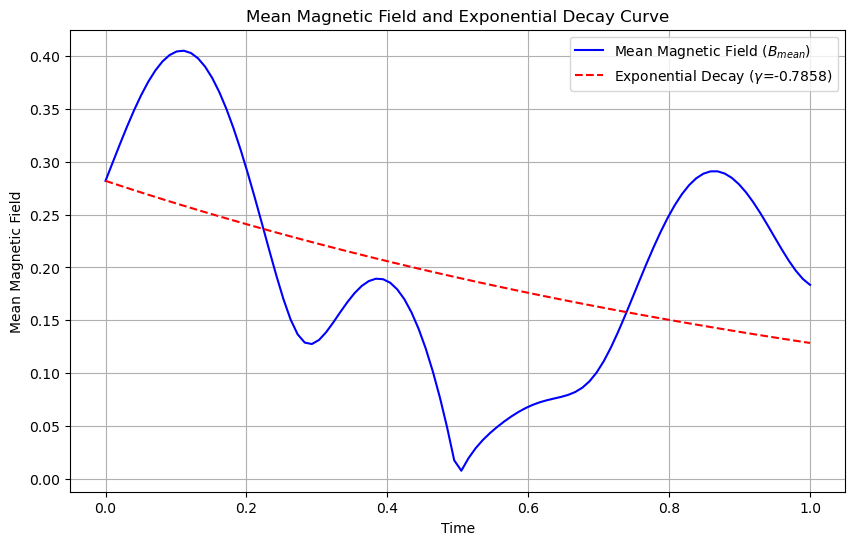

Magnetic Decay Constant: -0.785785


In [15]:

#Calculate mean magnetic field B_tilde over the spatial domain
B_mean = np.mean(B_total, axis=0)

#Fit an exponential decay curve to B_tilde over time to determine the decay constant gamma
def exponential_decay(t, gamma):
    return B_mean[0] * np.exp(gamma * t)

time = np.linspace(0, 1, 100)
gamma, _ = curve_fit(exponential_decay, time, B_mean)

#Plot the mean magnetic field B_tilde and the fitted exponential decay curve
plt.figure(figsize=(10, 6))
plt.plot(time, B_mean, label='Mean Magnetic Field ($B_{mean}$)', color='blue')
plt.plot(time, exponential_decay(time, *gamma), label=f'Exponential Decay ($\gamma$={gamma[0]:.4f})', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Mean Magnetic Field')
plt.title('Mean Magnetic Field and Exponential Decay Curve')
plt.legend()
plt.grid(True)
plt.show()

#Print the magnetic decay constant gamma
print(f"Magnetic Decay Constant: {gamma[0]:.6f}")

FileNotFoundError: [WinError 2] The system cannot find the file specified: '$B_{'

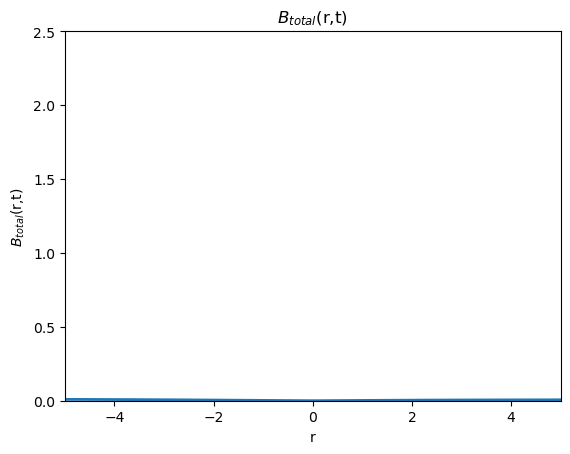

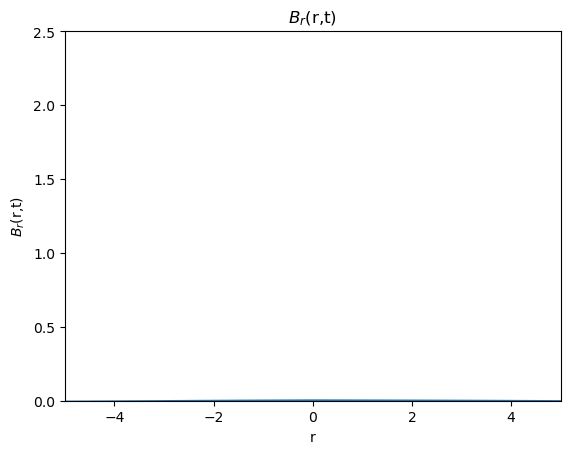

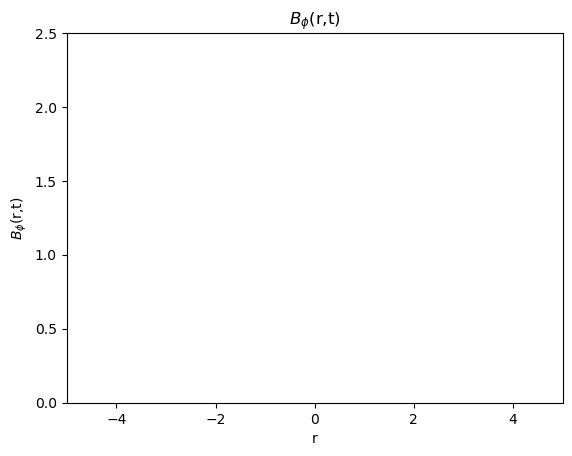

In [16]:
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter


def plot_animate(U, tspan, xspan, T, L, name):
    fig, ax = plt.subplots()
    ax.set_xlim(-L, L)
    ax.set_ylim(0, 2.5)
    ax.set_xlabel('r')
    ax.set_ylabel(f'{str(name)}(r,t)')
    ax.set_title(f'{str(name)}(r,t)')

    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(xspan, U[i])
        return line,

    ani = animation.FuncAnimation(fig, animate, frames=len(tspan), init_func=init, blit=True)
    ani.save(name+'.gif', writer='pillow', fps=60)  
    
    #Use FFMpegWriter and save as MP4


plot_animate(B_total,tspan, r, -L/2, L/2, '$B_{total}$')

plot_animate(Br_list,tspan, r, -L/2, L/2, '$B_r$')

plot_animate(Bphi_list,tspan, r, -L/2, L/2, '$B_{\phi}$')


